In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
from torchtext.vocab import GloVe
import nltk
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve

/opt/anaconda3/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/anaconda3/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
# Bag of words embedding
def get_bag_of_words_embedding(X_dev, X_test):
    word_embed_bow = CountVectorizer()
    X_dev_bow = word_embed_bow.fit_transform(X_dev)
    X_test_bow = word_embed_bow.transform(X_test)
    return X_dev_bow, X_test_bow

In [3]:
# TFIDF embedding
def get_tfidf_embedding(X_dev, X_test):
    word_embed_tfidf = TfidfVectorizer()
    X_dev_tfidf = word_embed_tfidf.fit_transform(X_dev)
    X_test_tfidf = word_embed_tfidf.transform(X_test)
    return X_dev_tfidf, X_test_tfidf

In [4]:
# GloVe embedding
def glove_sentence_embedding(sentence, max_length, embedding_dim, embeddings):
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((max_length, embedding_dim))

    for i in range(num_words):
        word = words[i]
        if word in embeddings.stoi:
            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]

    return embedding_sentence.flatten()

In [5]:
def get_glove_embedding(imdb_df):
    embeddings = GloVe(name='6B', dim=100)

    # Set the maximum sentence length and embedding dimension
    max_length = 100
    embedding_dim = 100

    imdb_df['encode_glove'] = imdb_df['review'].apply(
        lambda sentence: glove_sentence_embedding(sentence, max_length, embedding_dim, embeddings))
    X_glove = np.vstack(imdb_df['encode_glove'])
    return X_glove

In [6]:
def returnToTensor(txt):
    return eval("torch." + txt)

In [7]:
# Read in embedding file, 'review' column already preprocessed - bert column: 'cls_bert', glove column: 'encode_glove'
imdb_df = pd.read_csv('imdb_with_glove_bert_embeddings.csv')
imdb_df['cls_bert'] = imdb_df['cls_bert'].apply(returnToTensor)
imdb_df.drop('encode_glove', axis=1, inplace=True)

X = imdb_df['review']
y = imdb_df['sentiment']
X_bert = np.vstack(imdb_df['cls_bert'])
X_glove = get_glove_embedding(imdb_df)

labs = [1 if label == "positive" else 0 for label in y]
labels = np.array(labs)  # Convert to NumPy array

In [8]:
# Creating development and test sets for each embedding type
X_dev, X_test, y_dev, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
X_dev_tfidf, X_test_tfidf = get_tfidf_embedding(X_dev, X_test)
X_dev_bow, X_test_bow = get_bag_of_words_embedding(X_dev, X_test)

X_dev_bert, X_test_bert, y_dev_bert, y_test_bert = train_test_split(X_bert, labels, test_size=0.2, random_state=42)

X_dev_glove, X_test_glove, y_dev_glove, y_test_glove = train_test_split(X_glove, labels, test_size=0.2, random_state=42)

In [9]:
# Parameters for Grid Search
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],  
    'weights': ['uniform', 'distance'],          
    'metric': ['euclidean', 'minkowski']        
}

In [10]:
# Hyperparameter tuning for Bag of Words (Commented out due to high computation time - Model with best parameters in cell 14)
# knn_bow = KNeighborsClassifier()
# grid_search_bow = GridSearchCV(estimator=knn_bow, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_bow.fit(X_dev_bow, y_dev)
# print("Best Hyperparameters (Bag of Words):", grid_search_bow.best_params_)
# print("Best Score (Bag of Words):", grid_search_bow.best_score_)

In [11]:
# Hyperparameter tuning for BERT (Commented out due to high computation time - Model with best parameters in cell 15)
# knn_bert = KNeighborsClassifier()
# grid_search_bert = GridSearchCV(estimator=knn_bert, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_bert.fit(X_dev_bert, y_dev_bert)
# print("Best Hyperparameters (BERT):", grid_search_bert.best_params_)
# print("Best Score (BERT):", grid_search_bert.best_score_)

In [12]:
# Hyperparameter tuning for GloVe (Commented out due to high computation time - Model with best parameters in cell 16)
# knn_glove = KNeighborsClassifier()
# grid_search_glove = GridSearchCV(estimator=knn_glove, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_glove.fit(X_dev_glove, y_dev_glove)
# print("Best Hyperparameters (GloVe):", grid_search_glove.best_params_)
# print("Best Score (GloVe):", grid_search_glove.best_score_)

In [13]:
# Hyperparameter tuning for TF-IDF (Commented out due to high computation time - Model with best parameters in cell 17)
# knn_tfidf = KNeighborsClassifier()
# grid_search_tfidf = GridSearchCV(estimator=knn_tfidf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_tfidf.fit(X_dev_tfidf, y_dev)
# print("Best Hyperparameters (TF-IDF):", grid_search_tfidf.best_params_)
# print("Best Score (TF-IDF):", grid_search_tfidf.best_score_)

In [14]:
# Accuracy and Classification Report for Best BoW Model
knn_bow_best = KNeighborsClassifier(n_neighbors=21, metric='euclidean', weights='distance')
knn_bow_best.fit(X_dev_bow, y_dev)

y_pred_bow = knn_bow_best.predict(X_test_bow)

accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"Accuracy: {accuracy_bow:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_bow))

y_pred_proba_bow = knn_bow_best.predict_proba(X_test_bow)[:, 1]
auc_bow = roc_auc_score(y_test, y_pred_proba_bow)

Accuracy: 0.6492

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.75      0.68      4961
           1       0.69      0.55      0.61      5039

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



In [15]:
# Accuracy and Classification Report for Best BERT Model
knn_bert_best = KNeighborsClassifier(n_neighbors=21, metric='manhattan', weights='distance')
knn_bert_best.fit(X_dev_bert, y_dev_bert)

y_pred_bert = knn_bert_best.predict(X_test_bert)

accuracy_bert = accuracy_score(y_test_bert, y_pred_bert)
print(f"Accuracy: {accuracy_bert:.4f}")
print("\nClassification Report:\n", classification_report(y_test_bert, y_pred_bert))

y_pred_proba_bert = knn_bert_best.predict_proba(X_test_bert)[:, 1]
auc_bert = roc_auc_score(y_test_bert, y_pred_proba_bert)

Accuracy: 0.7491

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.87      0.77      4961
           1       0.83      0.63      0.72      5039

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.77      0.75      0.75     10000



In [16]:
# Accuracy and Classification Report for Best GloVe Model
knn_glove_best = KNeighborsClassifier(n_neighbors=21, metric='euclidean', weights='distance')
knn_glove_best.fit(X_dev_glove, y_dev_glove)

y_pred_glove = knn_glove_best.predict(X_test_glove)

accuracy_glove = accuracy_score(y_test_glove, y_pred_glove)
print(f"Accuracy: {accuracy_glove:.4f}")
print("\nClassification Report:\n", classification_report(y_test_glove, y_pred_glove))

y_pred_proba_glove = knn_glove_best.predict_proba(X_test_glove)[:, 1]
auc_glove = roc_auc_score(y_test_glove, y_pred_proba_glove)

Accuracy: 0.5466

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.69      0.60      4961
           1       0.57      0.41      0.48      5039

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.54     10000
weighted avg       0.55      0.55      0.54     10000



In [17]:
# Accuracy and Classification Report for Best TF-IDF Model
knn_tfidf_best = KNeighborsClassifier(n_neighbors=21, metric='euclidean', weights='distance')
knn_tfidf_best.fit(X_dev_tfidf, y_dev)

y_pred_tfidf = knn_tfidf_best.predict(X_test_tfidf)

accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f"Accuracy: {accuracy_tfidf:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_tfidf))

y_pred_proba_tfidf = knn_tfidf_best.predict_proba(X_test_tfidf)[:, 1]
auc_tfidf = roc_auc_score(y_test, y_pred_proba_tfidf)

Accuracy: 0.7992

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.78      4961
           1       0.77      0.86      0.81      5039

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



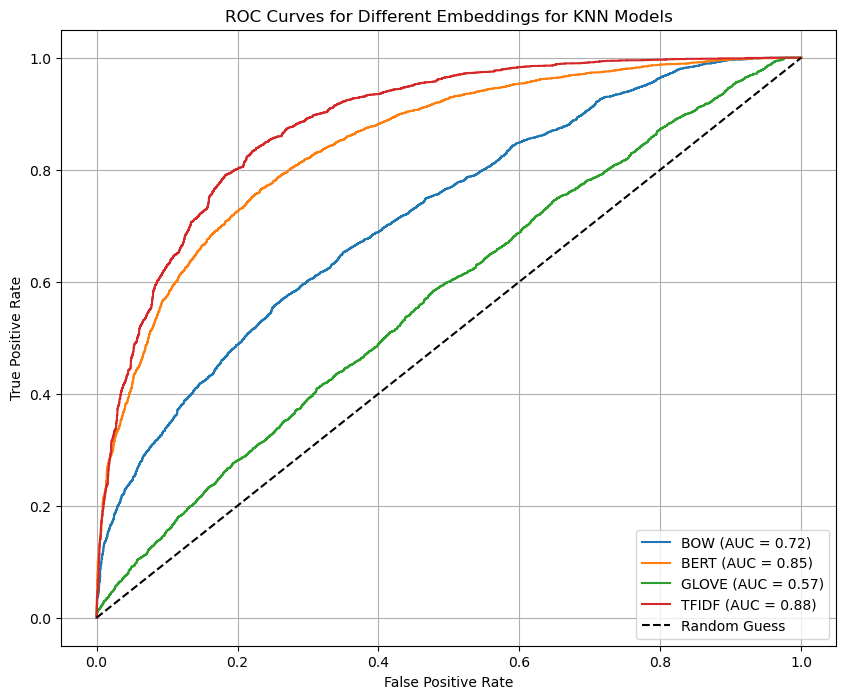

In [18]:
# ROC Curves
plt.figure(figsize=(10, 8))

# BoW
fpr_bow, tpr_bow, _ = roc_curve(y_test, y_pred_proba_bow)
plt.plot(fpr_bow, tpr_bow, label=f'BOW (AUC = {auc_bow:.2f})')

# BERT
fpr_bert, tpr_bert, _ = roc_curve(y_test, y_pred_proba_bert)
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {auc_bert:.2f})')

# GloVe
fpr_glove, tpr_glove, _ = roc_curve(y_test, y_pred_proba_glove)
plt.plot(fpr_glove, tpr_glove, label=f'GLOVE (AUC = {auc_glove:.2f})')

# TF-IDF
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, y_pred_proba_tfidf)
plt.plot(fpr_tfidf, tpr_tfidf, label=f'TFIDF (AUC = {auc_tfidf:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Embeddings for KNN Models')
plt.legend(loc='lower right')
plt.grid()
plt.show()